# **Example code with `bikit`**

In [1]:
#!pip install git+https://github.com/phiyodr/multilabel-oversampling
# or
#pip install multilabel-oversampling
import multilabel_oversampling as mo
mo.__version__

In [13]:
from bikit.utils import list_datasets, download_dataset
from bikit.utils import download_dataset
from bikit.datasets import BikitDataset
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [3]:
# Download data (about 500 MB)
DATASET_NAME = "mcds_bikit"
download_dataset(DATASET_NAME) 

/home/philipp/.cache/bikit already exists
/home/philipp/.cache/bikit and /home/philipp/.cache/bikit/mcds already exists.


# Code without upsampling

In [4]:
my_transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
train_dataset = BikitDataset(DATASET_NAME, split="train", transform=my_transform, return_type="pt") 
print("Shape before upsampling", train_dataset.df.shape)

Shape before upsampling (2057, 13)


#### Test if it is working

In [5]:
# There are no duplicates for the unique identifier `img_name` 
train_dataset.df["img_name"].duplicated().any()

False

In [6]:
# Show that DataLoader is working
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=False, num_workers=4)
for imgs, targets in train_loader:
    print(imgs.shape, "===>", targets.shape)
    break

torch.Size([64, 3, 256, 256]) ===> torch.Size([64, 8])


# Code with upsampling

Three times the number of samples should be sufficient for most datasets (but this depends on the imbalance of your dataset)

* `number_of_adds=len(train_dataset)*3`
* `number_of_tries=len(train_dataset)*3`

You need **2 lines** for upsampling and **2 more lines** to add upsampled dataset to `train_dataset`.

In [8]:
my_transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
train_dataset = BikitDataset(DATASET_NAME, split="train", transform=my_transform, return_type="pt") 

# Apply Upsampling based on train_dataset.df
moer = mo.MultilabelOversampler(number_of_adds=len(train_dataset)*3, number_of_tries=len(train_dataset)*3)
df_new = moer.fit(df=train_dataset.df, target_list=train_dataset.class_names) # Apply oversampling, this might take some time.

# Pass results to `train_dataset.df`
train_dataset.df = df_new # Pass new DataFrame to train_dataset
train_dataset.n_samples = train_dataset.df.shape[0] # Pass new DataFrame Length to train_dataset
print("Shape after upsampling", train_dataset.df.shape)

Start the upsampling process.


Iteration:  43%|██████████████████████████████████████████████████████████████                                                                                  | 2659/6171 [00:32<00:42, 82.71it/s]

Iter 2659: No improvement after 6171 tries.
Sampling done.

Dataset size original: 2057; Upsampled dataset size: 4716
Original target distribution:  {'Crack': 727.0, 'Efflorescence': 244.0, 'Scaling': 103.0, 'Spalling': 242.0, 'General': 204.0, 'NoDefect': 392.0, 'ExposedReinforcement': 101.0, 'RustStaining': 230.0}
Upsampled target distribution: {'Crack': 733.0, 'Efflorescence': 733.0, 'Scaling': 733.0, 'Spalling': 830.0, 'General': 733.0, 'NoDefect': 733.0, 'ExposedReinforcement': 636.0, 'RustStaining': 736.0}
Shape after upsampling (4716, 13)


#### Test if it is working and inspect results

In [9]:
# Now there should be duplicates for the unique identifier `img_name` 
train_dataset.df["img_name"].duplicated().any()

True

In [10]:
# Show that DataLoader is working
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=False, num_workers=4)
for imgs, targets in train_loader:
    print(imgs.shape, "===>", targets.shape)
    break

torch.Size([64, 3, 256, 256]) ===> torch.Size([64, 8])


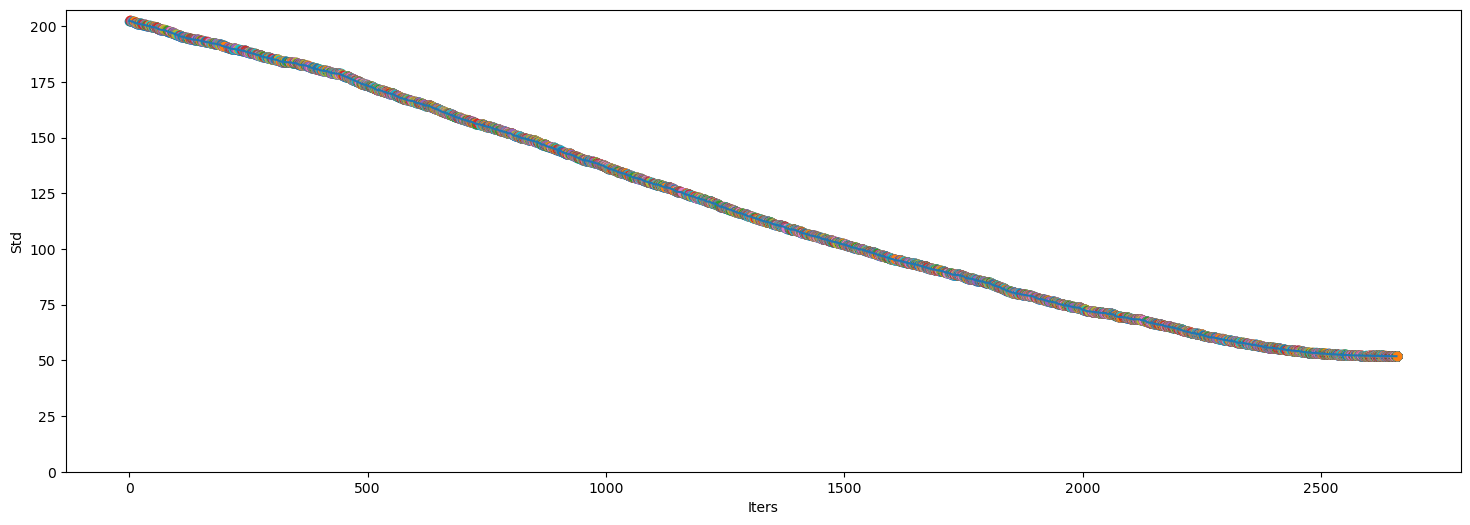

In [15]:
fig = plt.figure(figsize=(18, 6))
p = moer.plot_all_tries() # This plot takes a while

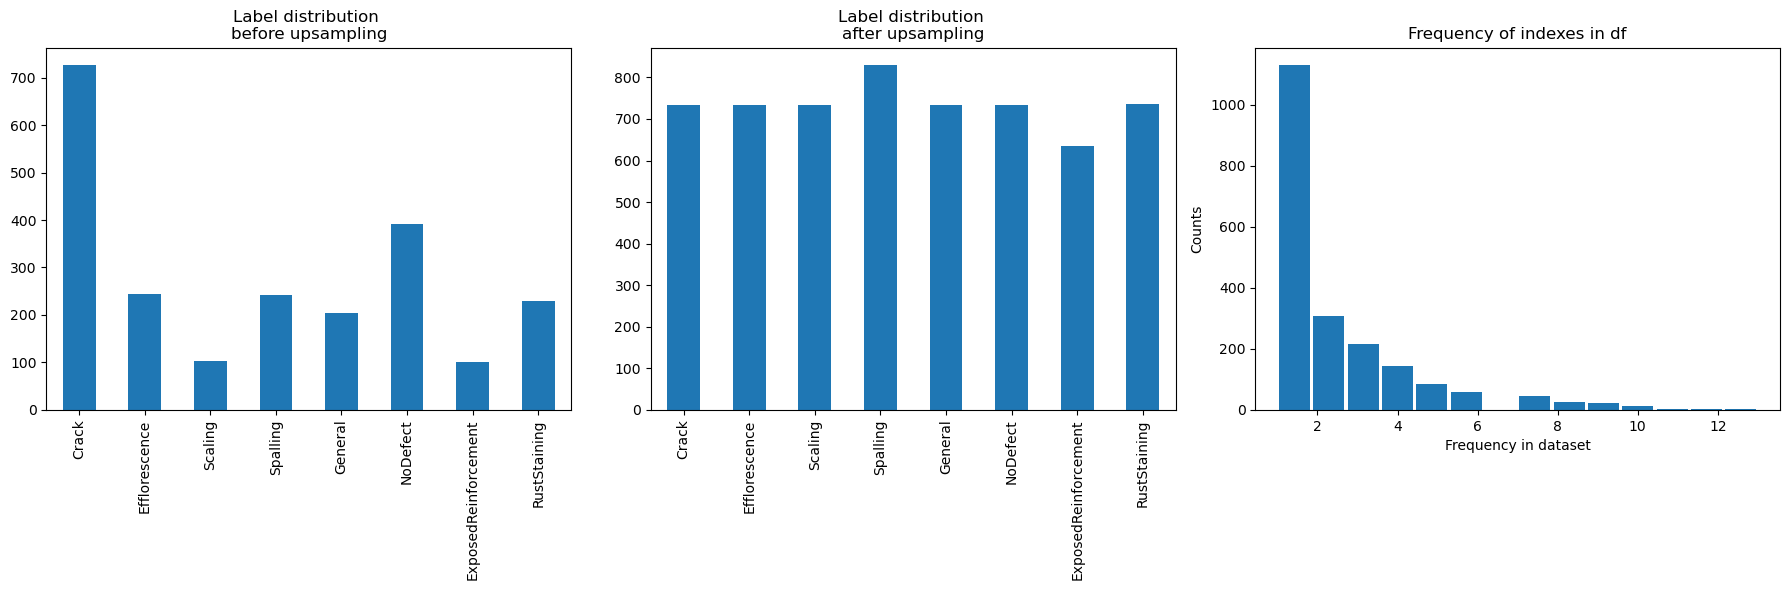

In [14]:
fig = plt.figure(figsize=(18, 6))
p = moer.plot_results()

1st plot (before upsampling):

* Many cracks, only a few scaling and Exposed Reinforcement

2nd plot (after upsampling)

* Targets almost evenly distributed

3rd plot:

* There are over 1000 images which appears only once on the new dataset.
* Around 400 appears twice.
* Some, freq images appear more than 8 times.